In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import multivariate_normal, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import inverse_train_test_procedure
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER,
                       plot_covariate_panel)

%load_ext autoreload
%autoreload 2

#aux
clocks = pd.read_pickle('subdata/clock_coefs.pkl')
clock = clocks['Horvath clock (353 CpGs)']

In [3]:
#Hannum blood humans
# dfa, meta = pd.read_pickle('datasets/GSE132203.pkl').values()
dfa = pd.read_parquet('datasets/computage_HC.parquet').T
meta = pd.read_csv('datasets/computage_bench_meta.tsv', sep='\t', index_col=0)
meta = meta.loc[dfa.index]

#CR humans
dfr, metr = pd.read_pickle('datasets/GSE240184.pkl').values()

print('Age, N sites', len(dfa.columns))
print('Rep, N sites', len(dfr.columns)) 
#low number of sites are accessible for in vivo reprogramming
#due to the poor intersection of samples with each other
#nevertheless, below we show that intersected sites are enough for clock construction

Age, N sites 900449
Rep, N sites 865918


## Check covariate shift

In [3]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]
Xa_clock = Xa_clock.fillna(Xa_clock.mean(axis=0))
Xr_clock = Xr_clock.fillna(Xr_clock.mean(axis=0).fillna(0.))

ya = meta['Age']
yr = metr['Age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock], axis=0))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

334 common sites


2.69% of sites are not rejected by KS test


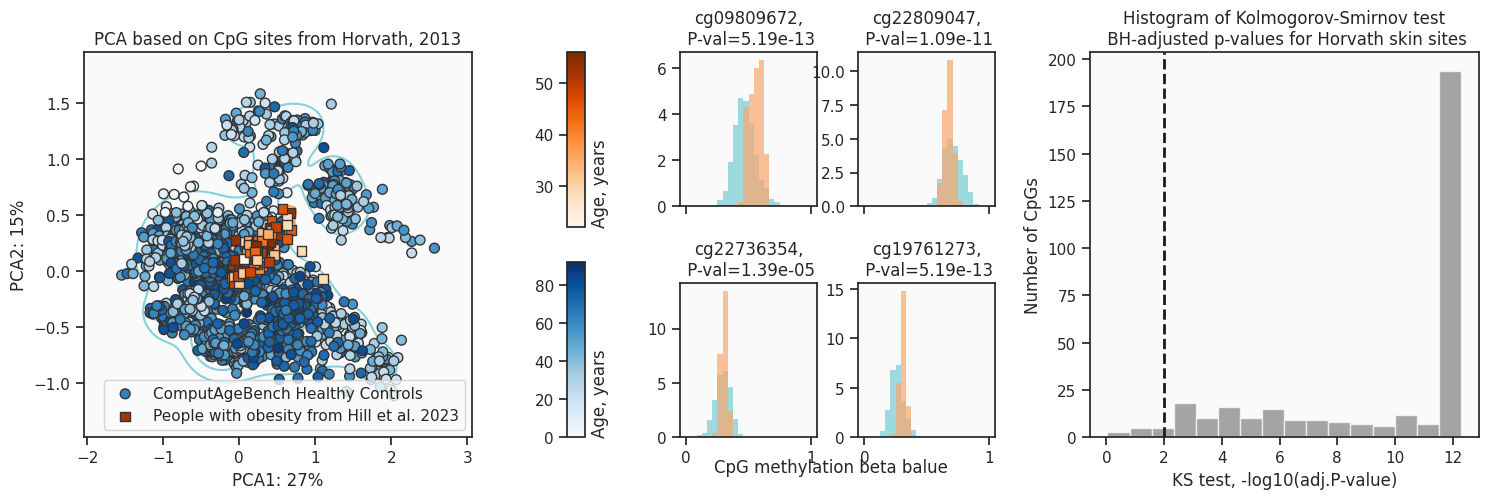

In [4]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.05,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'ComputAgeBench Healthy Controls',
                        legend_label_test = 'People with obesity from Hill et al. 2023',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'PCA based on CpG sites from Horvath, 2013',
                        pca_legend_pos = 'lower right',
                        # pca_xlim = [-1, 1.0],
                        # pca_ylim = [-1, 1.0] 
                        # custom_bins=np.linspace(0, 10, 10)
                        )

plt.savefig('figs/review/re_aging_blood_humans_cr.pdf', format='pdf', bbox_inches='tight')
plt.show()

# ITTP

In [4]:
# Thompson clocks
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]
Xa_clock = Xa_clock.fillna(Xa_clock.mean(axis=0))
Xr_clock = Xr_clock.fillna(Xr_clock.mean(axis=0).fillna(0.))

ya = meta['Age']
yr = metr['Age']

334 common sites


Step 1 results:
R2 train = 0.887
MAE train = 4.207
R2 test = 0.373
MAE test = 7.049
------------------------------
Step 2 results:
R2 train = 0.373
MAE train = 7.046
R2 test = 0.553
MAE test = 9.669
------------------------------


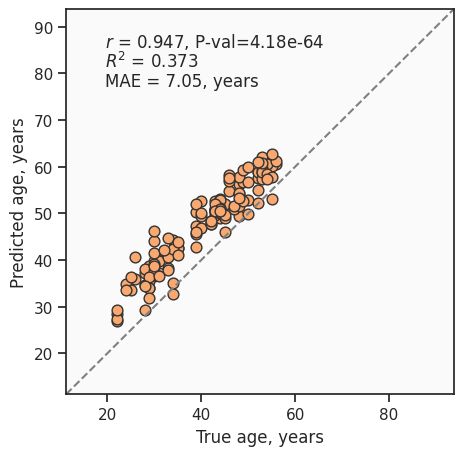

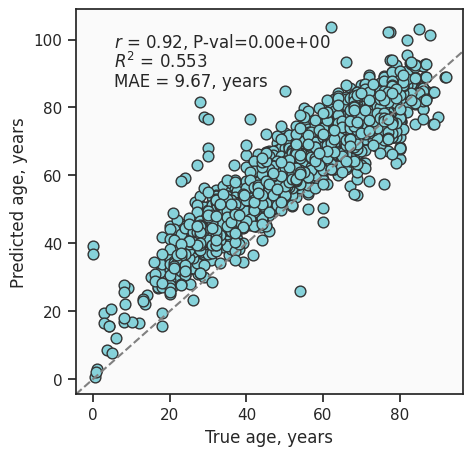

In [6]:
# Roos -> Vandiver
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=yr, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(15, 90), color='#f9a86f', markersize=60)
plt.savefig('figs/review/humans_aging_blood_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(15, 90), color='#86d2da', markersize=60)
plt.savefig('figs/humans_aging_blood_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

# GPR clock

334 common sites
R2 train = 0.9386166483034477
R2 test = 0.8830688316713486
MAE train = 3.1860286797821993
MAE test = 4.4536647199946495
------------------------------
Resulting kernel: 45.3**2 * RBF(length_scale=4.05) + WhiteKernel(noise_level=25.2)
Resulting kernel (full): 42.1**2 * RBF(length_scale=3.8) + WhiteKernel(noise_level=24.1)


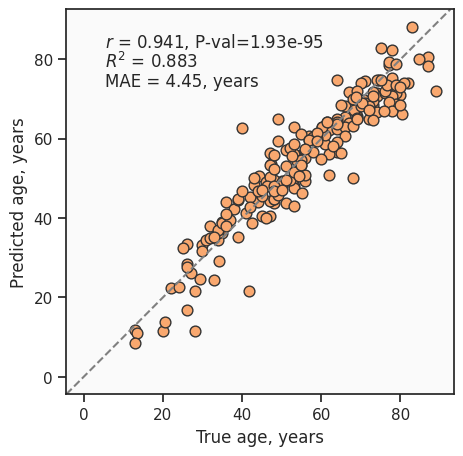

In [5]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]
Xa_clock = Xa_clock.fillna(Xa_clock.mean(axis=0))
Xr_clock = Xr_clock.fillna(Xr_clock.mean(axis=0).fillna(0.))

ya = meta['Age']
yr = metr['Age']

Xa_clock = Xa_clock.sample(1000, random_state=10)
ya = ya.loc[Xa_clock.index]
X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.20, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, 
                                 normalize_y=False, 
                                 n_restarts_optimizer=1)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='years')
plt.savefig('figs/review/GP_blood_human_test_performance.pdf', format='pdf', bbox_inches='tight')

# Refit on full data.
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

In [6]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr_ = metr.copy()
# metr_ = meta.loc[X_test.index]
metr_['gpr_age'] = y_test_predict_r
metr_['gpr_std'] = y_test_std_r
metr_['gpr_delta'] = metr_['gpr_age'] - metr_['Age']
metr_['Time point'] = metr_['_LongitudinalTimepoint'].map({'3m':'After 3 months', 'BL':'Baseline'})
metr_['SubjectID'] = [t[:3] for t in metr_['Title']]

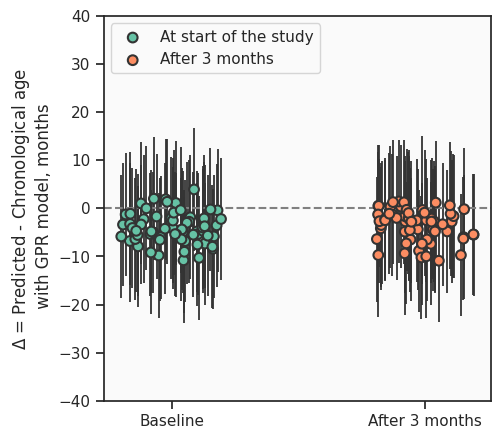

r test = 0.9447547372661775
R2 test = 0.7400087655292442
MAE test = 4.049221106209965


In [7]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
np.random.seed(10) #fix random seed for stripplot
strip = sns.stripplot(data=metr_, 
                x='Time point', 
                y='gpr_delta', 
				color='g',
                palette='Set2',
                jitter=0.2,
                s=7, linewidth=1.5, edgecolor="#333333",
                ax=ax,
				order=['Baseline', 'After 3 months']
				)
ax.set_xlabel('')
# ax.set_xticklabels(['CR'])

for age_group, coll in zip(sorted(metr_['Time point'].unique()), strip.collections):
	coords = coll.get_offsets().data
	ax.errorbar(y=coords[:, 1], 
				x=coords[:, 0], 
				yerr=metr_['gpr_std'][metr_['Time point'] == age_group], 
				linewidth=0, elinewidth=1.3, color='#333333')


plt.axhline(0, ls='--', color='grey')
ax.set_ylabel('$\Delta$ = Predicted - Chronological age \n with GPR model, months')
# ax.set_xlabel('Chronological age, months')
ax.legend(['At start of the study', 'After 3 months'], loc='upper left')
ax.set_ylim([-40, 40])
#ax.annotate()

plt.savefig('figs/review/CR_CI_humans.pdf', format='pdf', bbox_inches='tight')
plt.show()

print(f'r test = {np.corrcoef(yr, y_test_predict_r)[0,1]}')
print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

In [8]:
sub = metr_.copy()

from pymare import meta_regression
meta_df_ = meta_regression(
                sub['gpr_delta'].values, 
                sub['gpr_std'].values**2, 
                (sub[['Time point']] == 'After 3 months').values.astype(int),
                X_names=['Diet'], 
                add_intercept=True, 
                method='REML'
                ).to_df().set_index('name')
pval = meta_df_.loc['Diet', 'p-value']
print(f'P-value of diet effect is {pval}')
meta_df_

P-value of diet effect is 0.788797053569416


,estimate,se,z-score,p-value,ci_0.025,ci_0.975
name,,,,,,
intercept,-4.062009,1.600463,-2.538021,0.011148,-7.198859,-0.925159
Diet,0.606086,2.262587,0.267873,0.788797,-3.828503,5.040675


In [9]:
metr_[metr_['SubjectID']=='181']

,Title,Tissue,CellType,Gender,Age,Ethnicity,Condition,PlatformID,_LongitudinalTimepoint,gpr_age,gpr_std,gpr_delta,Time point,SubjectID
GSM7683984,181T3M,Blood,Whole blood,M,48,White (Non-Hispanic),CR,GPL21145,3m,37.105293,12.779197,-10.894707,After 3 months,181
GSM7684048,181BL,Blood,Whole blood,M,48,White (Non-Hispanic),CR,GPL21145,BL,41.208237,12.734577,-6.791763,Baseline,181


In [12]:
XX

,Time point,100,108,122,123,126,131,139,163,178,181,189,233,244,254,285,289,298,300,319,...,684,712,713,726,732,770,771,801,826,827,833,867,872,905,907,913,918,928,957,987
GSM7683975,1,After 3 months,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,
GSM7683976,1,,After 3 months,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,
GSM7683977,1,,,After 3 months,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,
GSM7683978,1,,,,After 3 months,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,
GSM7683979,1,,,,,After 3 months,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM7684098,0,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,Baseline,,,,
GSM7684099,0,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,Baseline,,,
GSM7684100,0,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,Baseline,,
GSM7684101,0,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,Baseline,


In [14]:
sub = metr_.copy()
# add coefficients for subject IDs to the model 
dummyID = pd.get_dummies(sub['SubjectID'])
#this allows to use mixed slopes model instead of intercepts
sub['Time point'] = (sub['Time point'] == 'After 3 months').astype(int)
dummyID = dummyID.multiply(sub['Time point'].values, axis=0) 

XX = pd.concat([sub[['Time point']], dummyID], axis=1)

from pymare import meta_regression
meta_df_ = meta_regression(
                sub['gpr_delta'].values, 
                sub['gpr_std'].values**2 ,#/ sub['gpr_std'].values**2, 
                XX.values,
                X_names=XX.columns, 
                add_intercept=True, 
                method='REML'
                ).to_df().set_index('name')
pval = meta_df_.loc['Time point', 'p-value']
print(f'P-value of diet effect is {pval}')
meta_df_

P-value of diet effect is 0.8020447375821331


,estimate,se,z-score,p-value,ci_0.025,ci_0.975
name,,,,,,
intercept,-4.062009,1.600463,-2.538021,0.011148,-7.198859,-0.925159
Time point,0.560351,2.235131,0.250702,0.802045,-3.820424,4.941126
100,-6.208982,12.771544,-0.486158,0.626855,-31.240748,18.822784
108,-2.986271,12.674989,-0.235603,0.813740,-27.828792,21.856251
122,0.552236,12.629831,0.043725,0.965124,-24.201778,25.306250
...,...,...,...,...,...,...
913,4.121670,12.798141,0.322052,0.747413,-20.962226,29.205566
918,-3.853442,12.660552,-0.304366,0.760849,-28.667667,20.960784
928,-1.311450,12.698660,-0.103275,0.917745,-26.200366,23.577466


In [15]:
exclude = ['905', '436', '681', '319'] #exclude individuals with more than 2 measurements (4 in total)
metr_ = metr_[~metr_['SubjectID'].isin(exclude)]
m3 = metr_[metr_['Time point'] == 'After 3 months'][['SubjectID', 'gpr_delta', 'gpr_age']].sort_values('SubjectID')
bl = metr_[metr_['Time point'] == 'Baseline'][['SubjectID', 'gpr_delta', 'gpr_age']].sort_values('SubjectID')

(m3['gpr_age'].values - bl['gpr_age'].values).mean() #increase in aging after 3 month

0.46104402287690405